In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sms
import pandas as pd

%matplotlib inline

In [2]:
# dataset
url = 'https://raw.githubusercontent.com/krishnaik06/Live-Time-Series/refs/heads/main/airline_passengers.csv'
df = pd.read_csv(url)
df.head()


,Month,Thousands of Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [3]:
df.isnull().sum()

,0
Month,0
Thousands of Passengers,1


In [4]:
# dropping the nulls
df.dropna(axis=0,inplace=True)
df.isnull().sum()

,0
Month,0
Thousands of Passengers,0


In [5]:
# checking the info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    144 non-null    object 
 1   Thousands of Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


In [6]:
# converting month to datetime type
df['Month']=pd.to_datetime(df['Month'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    144 non-null    datetime64[ns]
 1   Thousands of Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [10]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


<Axes: xlabel='Month'>

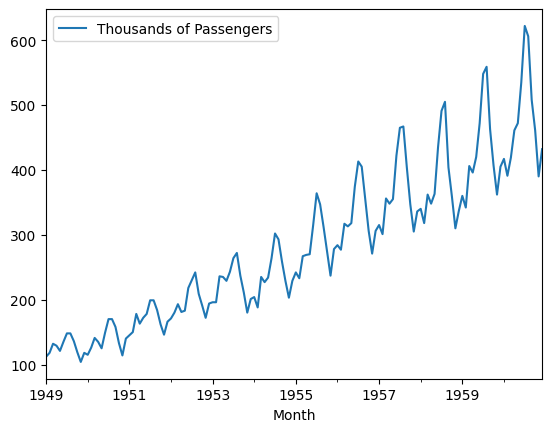

In [11]:
# lets make the timestamp the index
#df.set_index('Month',inplace=True)
#df.head()
df.plot()

# **Dickey–Fuller test**

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [14]:
adf_test(df['Thousands of Passengers'])

ADF Statistics: 0.8153688792060498
p- value: 0.991880243437641
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


# **Differencing**

In [15]:
## Use Techniques Differencing
df['Passengers First Difference']=df['Thousands of Passengers']-df['Thousands of Passengers'].shift(1)
df.head()

,Thousands of Passengers,Passengers First Difference
Month,,
1949-01-01,112.0,NaN
1949-02-01,118.0,6.0
1949-03-01,132.0,14.0
1949-04-01,129.0,-3.0
1949-05-01,121.0,-8.0


In [16]:
# repeat the test with the new difference
adf_test(df['Passengers First Difference'].dropna())

ADF Statistics: -2.8292668241700047
p- value: 0.05421329028382478
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [17]:
# lets repeat the differencing
df['Passengers Second Difference']=df['Passengers First Difference']-df['Passengers First Difference'].shift(1)
df.head()

,Thousands of Passengers,Passengers First Difference,Passengers Second Difference
Month,,,
1949-01-01,112.0,NaN,NaN
1949-02-01,118.0,6.0,NaN
1949-03-01,132.0,14.0,8.0
1949-04-01,129.0,-3.0,-17.0
1949-05-01,121.0,-8.0,-5.0


In [18]:
# dickey test on the second
adf_test(df['Passengers Second Difference'].dropna())

ADF Statistics: -16.384231542468513
p- value: 2.7328918500142026e-29
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


# **Autocorrelation**

In [19]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

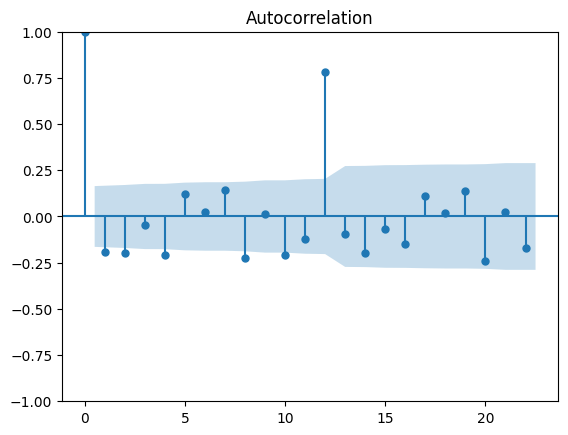

In [20]:
acf = plot_acf(df["Passengers Second Difference"].dropna())

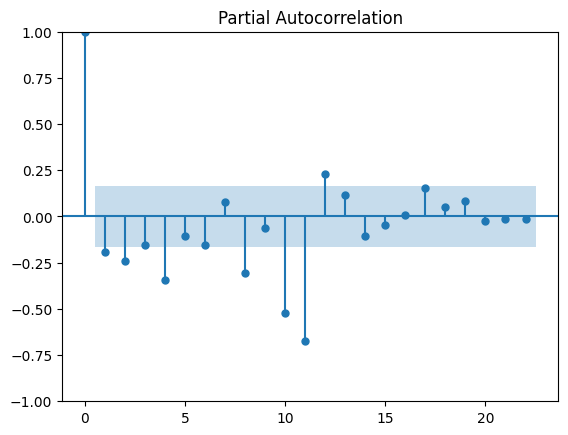

In [23]:
result = plot_pacf(df["Passengers Second Difference"].dropna())

In [21]:
# testing out the anual difference
df['Passengers 12 Difference']=df['Thousands of Passengers']-df['Thousands of Passengers'].shift(12)
adf_test(df['Passengers 12 Difference'].dropna())

ADF Statistics: -3.383020726492481
p- value: 0.011551493085514952
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


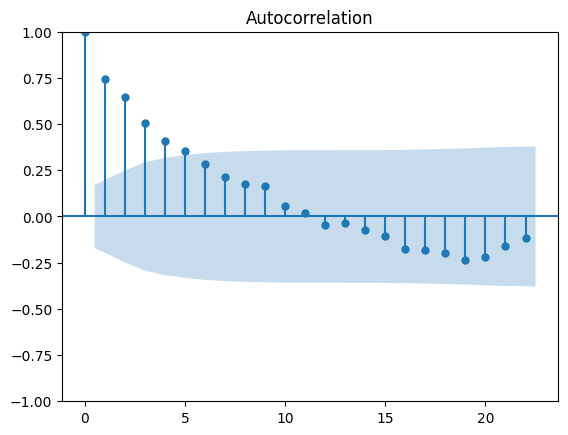

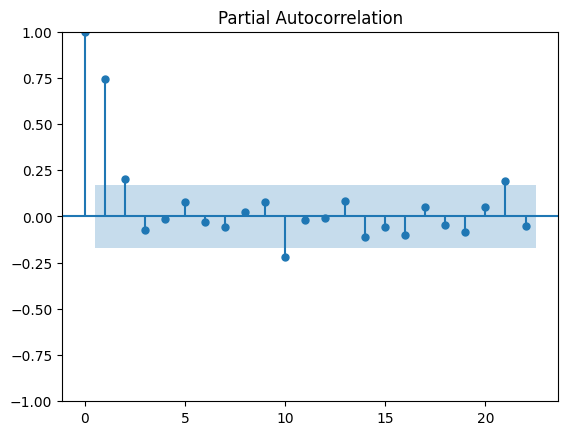

In [22]:
acf12 = plot_acf(df["Passengers 12 Difference"].dropna())
pacf12 = plot_pacf(df["Passengers 12 Difference"].dropna())

In [24]:
# split
from datetime import datetime,timedelta
train_dataset_end=datetime(1955,12,1)
test_dataset_end=datetime(1960,12,1)

In [25]:
train_data=df[:train_dataset_end]
test_data=df[train_dataset_end+timedelta(days=1):test_dataset_end]

In [26]:
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]

# **ARIMA**

In [30]:
from statsmodels.tsa.arima.model import ARIMA

In [31]:
train_data.head()

,Thousands of Passengers,Passengers First Difference,Passengers Second Difference,Passengers 12 Difference
Month,,,,
1949-01-01,112.0,NaN,NaN,NaN
1949-02-01,118.0,6.0,NaN,NaN
1949-03-01,132.0,14.0,8.0,NaN
1949-04-01,129.0,-3.0,-17.0,NaN
1949-05-01,121.0,-8.0,-5.0,NaN


In [32]:
model_ARIMA=ARIMA(train_data['Thousands of Passengers'],order=(10,2,12))
model_Arima_fit=model_ARIMA.fit()
model_Arima_fit.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Thousands of Passengers   No. Observations:                   84
Model:                    ARIMA(10, 2, 12)   Log Likelihood                -307.736
Date:                     Thu, 29 May 2025   AIC                            661.472
Time:                             23:57:52   BIC                            716.826
Sample:                         01-01-1949   HQIC                           683.696
                              - 12-01-1955                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0468      0.115      0.408      0.683      -0.178       0.272
ar.L2         -1.0428      0.084    -12.475      0.000      -1.207      -0.879
ar.L3          0.0886      0.139      0.638      0.523      -0.183       0.361
ar.L4         -1.0258      0.131     -7.823      0.000      -1.283      -0.769
ar.L5          0.0658      0.155      0.423      0.672      -0.239       0.370
ar.L6         -0.9860      0.143     -6.881      0.000      -1.267      -0.705
ar.L7          0.0175      0.142      0.123      0.902      -0.261       0.296
ar.L8         -0.9821      0.122     -8.028      0.000      -1.222      -0.742
ar.L9         -0.0069      0.095     -0.073      0.942      -0.193       0.179
ar.L10        -0.9389      0.085    -11.096      0.000      -1.105      -0.773
ma.L1         -1.2855      0.254     -5.057      0.000      -1.784      -0.787
ma.L2          1.2393      0.359      3.454      0.001       0.536       1.942
ma.L3         -1.4414      0.437     -3.301      0.001      -2.297      -0.585
ma.L4          1.3762      0.507      2.713      0.007       0.382       2.371
ma.L5         -1.2168      0.575     -2.116      0.034      -2.344      -0.089
ma.L6          1.0833      0.661      1.640      0.101      -0.212       2.378
ma.L7         -1.0703      0.715     -1.497      0.134      -2.472       0.331
ma.L8          0.8862      0.819      1.082      0.279      -0.719       2.492
ma.L9         -0.7853      0.737     -1.066      0.287      -2.230       0.659
ma.L10         0.5230      0.602      0.869      0.385      -0.656       1.702
ma.L11        -0.4130      0.455     -0.908      0.364      -1.305       0.479
ma.L12         0.1338      0.273      0.489      0.625      -0.402       0.669
sigma2        77.2860     16.222      4.764      0.000      45.492     109.080
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.74
Prob(Q):                              0.99   Prob(JB):                         0.09
Heteroskedasticity (H):               2.12   Skew:                             0.59
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
##prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]
print(pred_start_date)
print(pred_end_date)

1956-01-01 00:00:00
1960-12-01 00:00:00


In [34]:
pred=model_Arima_fit.predict(start=pred_start_date,end=pred_end_date)
residuals=test_data['Thousands of Passengers']-pred

In [35]:
pred

,predicted_mean
1956-01-01,283.235324
1956-02-01,269.506185
1956-03-01,295.175184
1956-04-01,298.583232
1956-05-01,299.096082
1956-06-01,345.352397
1956-07-01,388.481907
1956-08-01,371.893656
1956-09-01,340.100624
1956-10-01,302.904173


<Axes: ylabel='Density'>

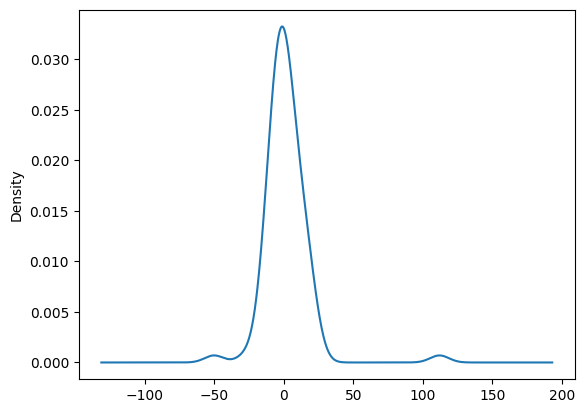

In [36]:
model_Arima_fit.resid.plot(kind='kde')

In [37]:
test_data['Predicted_ARIMA']=pred

<ipython-input-37-69896c9f46c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_ARIMA']=pred


<Axes: xlabel='Month'>

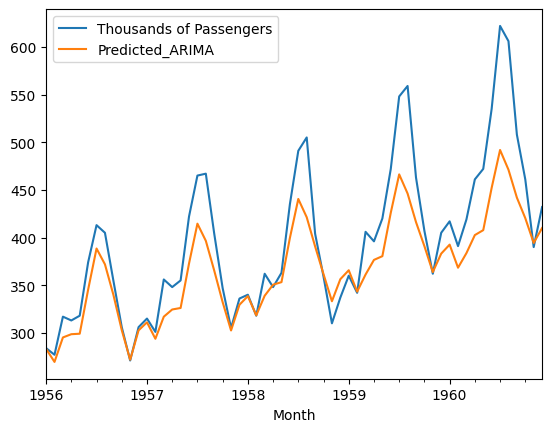

In [38]:
test_data[['Thousands of Passengers','Predicted_ARIMA']].plot()

# **SARIMAX Model**

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [40]:
model_SARIMA=SARIMAX(train_data['Thousands of Passengers'],order=(3,0,5),seasonal_order=(0,1,0,12))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [41]:
model_SARIMA_fit=model_SARIMA.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
model_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             Thousands of Passengers   No. Observations:                   84
Model:             SARIMAX(3, 0, 5)x(0, 1, [], 12)   Log Likelihood                -265.240
Date:                             Fri, 30 May 2025   AIC                            548.480
Time:                                     00:10:34   BIC                            568.970
Sample:                                 01-01-1949   HQIC                           556.638
                                      - 12-01-1955                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5974      0.937      0.637      0.524      -1.240       2.434
ar.L2          0.8310      0.232      3.584      0.000       0.377       1.285
ar.L3         -0.4516      0.893     -0.505      0.613      -2.203       1.299
ma.L1          0.1847      1.167      0.158      0.874      -2.103       2.472
ma.L2         -0.5333      1.265     -0.422      0.673      -3.012       1.945
ma.L3         -0.0988      0.385     -0.256      0.798      -0.854       0.656
ma.L4         -0.1275      0.339     -0.376      0.707      -0.792       0.537
ma.L5          0.2470      0.358      0.691      0.490      -0.454       0.948
sigma2        87.7349     81.586      1.075      0.282     -72.170     247.640
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.69
Prob(Q):                              0.88   Prob(JB):                         0.26
Heteroskedasticity (H):               2.05   Skew:                             0.46
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
##prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]
print(pred_start_date)
print(pred_end_date)

1956-01-01 00:00:00
1960-12-01 00:00:00


In [44]:
pred_Sarima=model_SARIMA_fit.predict(start=datetime(1956,6,6),end=datetime(1960,12,1))
residuals=test_data['Thousands of Passengers']-pred_Sarima

<Axes: xlabel='Month'>

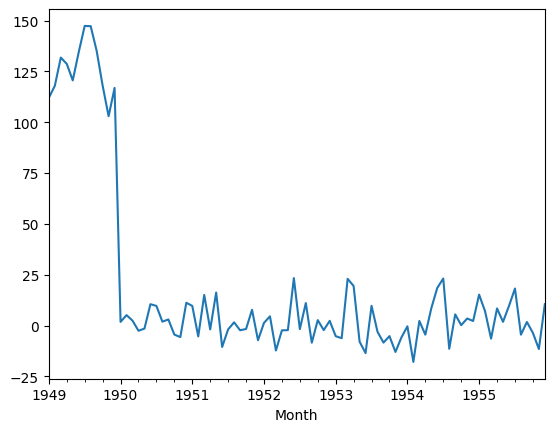

In [46]:
model_SARIMA_fit.resid.plot()

<Axes: ylabel='Density'>

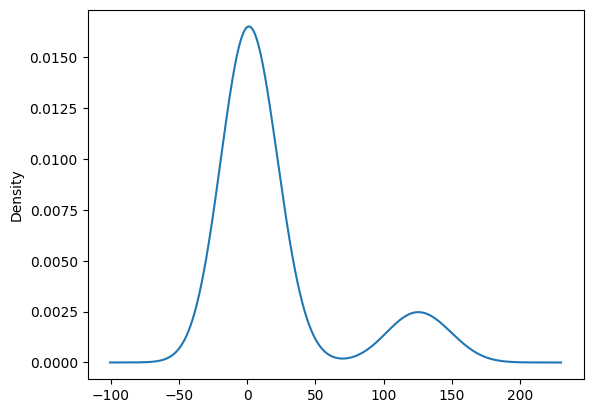

In [47]:
model_SARIMA_fit.resid.plot(kind='kde')

In [48]:
test_data['Predicted_SARIMA']=pred_Sarima

<ipython-input-48-5be0f969ecf6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_SARIMA']=pred_Sarima


<Axes: xlabel='Month'>

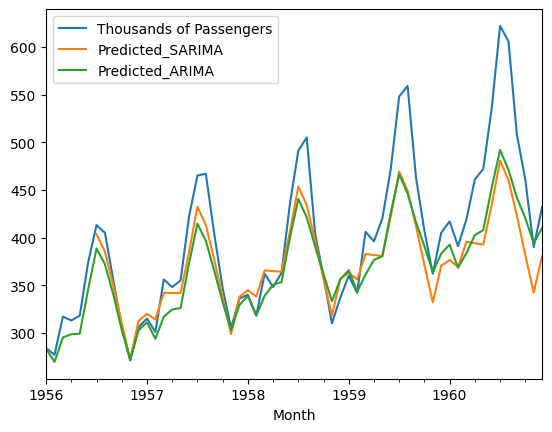

In [49]:
test_data[['Thousands of Passengers','Predicted_SARIMA','Predicted_ARIMA']].plot()